(64,)
40
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [23. 24. 25. 26. 18. 19. 20. 21.]
 [18. 19. 20. 21. 13. 14. 15. 16.]
 [13. 14. 15. 16.  8.  9. 10. 11.]]


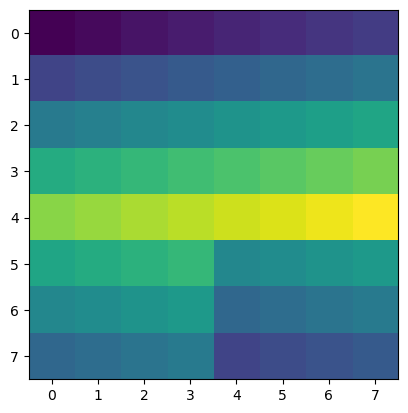

In [1]:
import numpy as np
ntheta = 5
npix = 40
nphi = npix//ntheta
synth1D = np.arange((ntheta * nphi))
doubling1D = np.zeros(((2 * ntheta - 2)* nphi))
import matplotlib.pyplot as plt
print(doubling1D.shape)

nphihalf = nphi // 2
print(ntheta*nphi)
for i in range(ntheta):
    for j in range(nphi):
        doubling1D[i * nphi + j] = synth1D[i * nphi + j]
for i in range(ntheta, 2 * ntheta-2, 1):
    for j in range(0, nphihalf):
        doubling1D[i * nphi + j] = np.copy(synth1D[2*ntheta-2 - i * (ntheta) + j])
for i in range(ntheta, 2 * ntheta-2, 1):
    for j in range(nphihalf, nphi):
        doubling1D[i * nphi + j] = synth1D[ntheta - i * (ntheta)-2 + j - nphihalf]


# print(synth1D)

np.array(doubling1D)

# del synth1D, doubling1D
plt.imshow(doubling1D.reshape(2*ntheta - 2, nphi))

print(doubling1D.reshape(2*ntheta - 2, nphi))

In [135]:
print(doubling1D_py)

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [28. 29. 30. 31. 24. 25. 26. 27.]
 [20. 21. 22. 23. 16. 17. 18. 19.]
 [12. 13. 14. 15.  8.  9. 10. 11.]]


In [83]:
doubling1D_py = np.zeros((2 * ntheta-2, nphi))
print(doubling1D_py.flatten().shape)
synth1D_py = np.copy(synth1D.reshape(ntheta, nphi))
print(synth1D_py.shape, doubling1D_py[:ntheta, :].shape)

nphihalf = nphi//2
doubling1D_py[:ntheta, :] = synth1D_py
doubling1D_py[ntheta:, :nphihalf] = doubling1D_py[ntheta-2:0:-1, nphihalf:]
doubling1D_py[ntheta:, nphihalf:] = doubling1D_py[ntheta-2:0:-1, :nphihalf]

doubling1D_py.flatten()

(64,)
(5, 8) (5, 8)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 28., 29., 30., 31., 24., 25., 26., 27., 20., 21., 22., 23.,
       16., 17., 18., 19., 12., 13., 14., 15.,  8.,  9., 10., 11.])

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [28. 29. 30. 31. 24. 25. 26. 27.]
 [20. 21. 22. 23. 16. 17. 18. 19.]
 [12. 13. 14. 15.  8.  9. 10. 11.]]


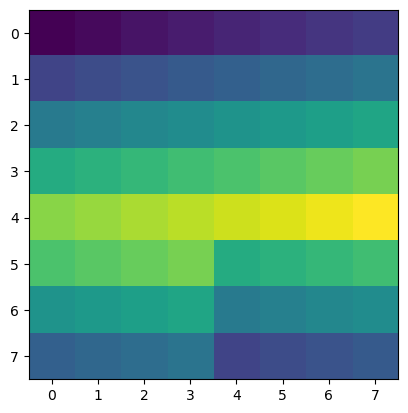

In [14]:
synth1D_py

array([[0.06488395, 0.89119387, 0.83396506, 0.53406297, 0.19324491,
        0.18381148, 0.61585604, 0.02950532],
       [0.09691744, 0.01195941, 0.75509692, 0.521626  , 0.72050291,
        0.92042311, 0.15874288, 0.11785826],
       [0.26297592, 0.05287091, 0.82998709, 0.66686171, 0.15670044,
        0.28794626, 0.62448104, 0.19878425],
       [0.98733512, 0.81630902, 0.96169815, 0.68280076, 0.40582675,
        0.65857582, 0.45086894, 0.9623192 ]])

In [2]:
import healpy as hp
hp.nside2npix(2048)

50331648